<a href="https://colab.research.google.com/github/srujanay18/lab_tree_stability/blob/main/Final_lab_tree_stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Pick one of the datasets and appropriately clean it

In [1]:
# load and clean dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df = pd.read_csv('airbnb_hw.csv')
df.columns = df.columns.str.strip()

vars_to_keep = ['Price', 'Beds', 'Number Of Reviews', 'Review Scores Rating', 'Room Type']
df = df[vars_to_keep]

# make price numeric and drop the rows with missing price or room type
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.dropna(subset=['Price', 'Room Type'])

# for missing numeric values, fill in with the median for that column
numeric_vars = ['Beds', 'Number Of Reviews', 'Review Scores Rating']
for var in numeric_vars:
    df[var] = df[var].fillna(df[var].median())

# one hot encode the room type variable
X = df[numeric_vars + ['Room Type']]
X = pd.get_dummies(X, columns=['Room Type'], drop_first=True)

y = df['Price']

print("Feature matrix shape:", X.shape)
print("\nSummary of numeric variables (including Price):")
print(df[numeric_vars + ['Price']].describe())


Feature matrix shape: (30297, 5)

Summary of numeric variables (including Price):
               Beds  Number Of Reviews  Review Scores Rating         Price
count  30297.000000       30297.000000          30297.000000  30297.000000
mean       1.517906          12.074166             92.531142    153.357032
std        0.982662          22.026957              7.609674    108.895698
min        0.000000           0.000000             20.000000     10.000000
25%        1.000000           0.000000             90.000000     80.000000
50%        1.000000           3.000000             94.000000    125.000000
75%        2.000000          13.000000             97.000000    192.000000
max       16.000000         257.000000            100.000000    999.000000


# Part 2: Perform a train-test split for a specific seed (save the seed for reproducibility). Fit a classification/regression tree and a linear model on the training data and evaluate their performance on the test data. Set aside the predictions these models make.

In [2]:
base_seed = 123
test_size = 0.2

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X, y, test_size=test_size, random_state=base_seed
)

# decision tree regressor
tree_base = tree.DecisionTreeRegressor(
    max_depth=6,
    min_samples_leaf=50,
    random_state=base_seed
)
tree_base = tree_base.fit(X_train_base, y_train_base)
y_hat_tree_base = tree_base.predict(X_test_base)

# linear regression
lin_base = LinearRegression()
lin_base = lin_base.fit(X_train_base, y_train_base)
y_hat_lin_base = lin_base.predict(X_test_base)

# R^2
SSE_tree = np.sum((y_test_base - y_hat_tree_base) ** 2)
TSS = np.sum((y_test_base - y_test_base.mean()) ** 2)
R2_tree_base = 1 - SSE_tree / TSS

SSE_lin = np.sum((y_test_base - y_hat_lin_base) ** 2)
R2_lin_base = 1 - SSE_lin / TSS

print("Baseline seed:", base_seed)
print("Decision tree R^2 on test:", R2_tree_base)
print("Linear model R^2 on test:", R2_lin_base)


Baseline seed: 123
Decision tree R^2 on test: 0.36437888927330675
Linear model R^2 on test: 0.35161758494206097


On the baseline split, the tree and linear model had similar test R^2, with the tree being slightly better. So both models explained a similar amount of variation in price and neither outperformed the other by much.

# Part 3: Repeat step 2 for three to five different seeds (save the seeds for reproducibility). How different are the trees that you get? Your linear model coefficients?. Set aside the predictions these models make.

In [3]:
# use modeling with different seeds
other_seeds = [5, 42, 99, 2024]

alt_tree_preds = {}
alt_lin_preds = {}
tree_depths = {base_seed: tree_base.get_depth()}
lin_coefs = {base_seed: lin_base.coef_}
r2_tree = {base_seed: R2_tree_base}
r2_lin = {base_seed: R2_lin_base}

for s in other_seeds:
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X, y, test_size=test_size, random_state=s
    )

    # decision tree for this seed
    tree_s = tree.DecisionTreeRegressor(
        max_depth=6,
        min_samples_leaf=50,
        random_state=s
    )
    tree_s = tree_s.fit(X_train_s, y_train_s)

    # R^2 on this seed's test split
    y_hat_tree_s_test = tree_s.predict(X_test_s)
    SSE_tree_s = np.sum((y_test_s - y_hat_tree_s_test) ** 2)
    TSS_s = np.sum((y_test_s - y_test_s.mean()) ** 2)
    r2_tree[s] = 1 - SSE_tree_s / TSS_s

    # predictions on the original test set
    alt_tree_preds[s] = tree_s.predict(X_test_base)
    tree_depths[s] = tree_s.get_depth()

    # linear regression for this seed
    lin_s = LinearRegression()
    lin_s = lin_s.fit(X_train_s, y_train_s)

    y_hat_lin_s_test = lin_s.predict(X_test_s)
    SSE_lin_s = np.sum((y_test_s - y_hat_lin_s_test) ** 2)
    r2_lin[s] = 1 - SSE_lin_s / TSS_s

    alt_lin_preds[s] = lin_s.predict(X_test_base)
    lin_coefs[s] = lin_s.coef_

print("Decision tree R^2 by seed:", r2_tree)
print("Linear model R^2 by seed:", r2_lin)


Decision tree R^2 by seed: {123: np.float64(0.36437888927330675), 5: np.float64(0.3428863831265955), 42: np.float64(0.3467650953154219), 99: np.float64(0.3871432021507716), 2024: np.float64(0.35029156941294715)}
Linear model R^2 by seed: {123: np.float64(0.35161758494206097), 5: np.float64(0.33741104767568786), 42: np.float64(0.3370916941323012), 99: np.float64(0.3869810591641064), 2024: np.float64(0.34589430659448983)}


In [4]:
# look at how different the trees and linear coefficients are
print("Tree depths by seed:")
for s in sorted(tree_depths.keys()):
    print("Seed", s, "-> depth:", tree_depths[s])

print("\nLinear regression coefficients by seed (aligned with columns in X):")
coef_names = list(X.columns)
for s in sorted(lin_coefs.keys()):
    print("\nSeed", s)
    coef_series = pd.Series(lin_coefs[s], index=coef_names)
    print(coef_series)


Tree depths by seed:
Seed 5 -> depth: 6
Seed 42 -> depth: 6
Seed 99 -> depth: 6
Seed 123 -> depth: 6
Seed 2024 -> depth: 6

Linear regression coefficients by seed (aligned with columns in X):

Seed 5
Beds                       31.962668
Number Of Reviews          -0.224098
Review Scores Rating        1.046825
Room Type_Private room    -91.537932
Room Type_Shared room    -112.087014
dtype: float64

Seed 42
Beds                       32.427142
Number Of Reviews          -0.230643
Review Scores Rating        0.999700
Room Type_Private room    -90.832087
Room Type_Shared room    -112.483659
dtype: float64

Seed 99
Beds                       31.905650
Number Of Reviews          -0.227415
Review Scores Rating        0.999646
Room Type_Private room    -91.241407
Room Type_Shared room    -110.549900
dtype: float64

Seed 123
Beds                       32.138143
Number Of Reviews          -0.226013
Review Scores Rating        1.011664
Room Type_Private room    -92.256317
Room Type_Shared room   

When looking at the different seeds, the tree structures changed a lot more than the linear models did. The linear coefficients stayed very close in value (same signs), but the trees changed which splits they used even though their overall performance (test R^2) stayed in a similar range.

# Part 4a: Make scatterplots of the predicted values on the test set from question 2 against the predicted values for the alternative models from part 3, separately for your trees and linear models. Do they appear reasonably similar?

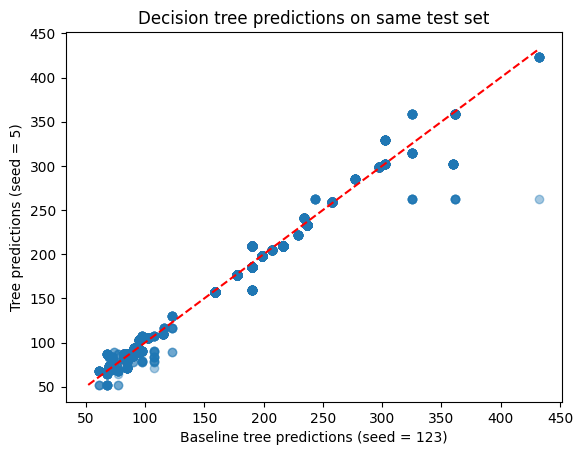

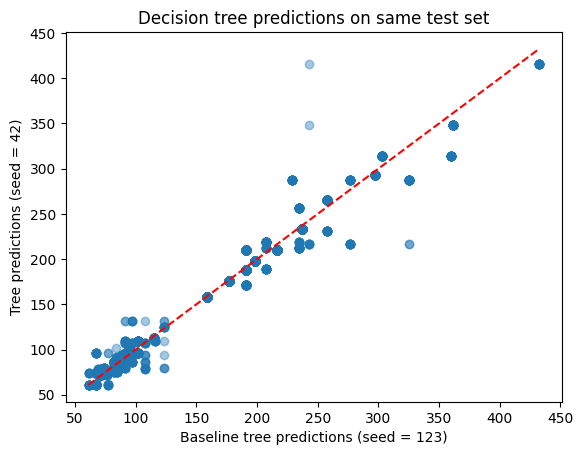

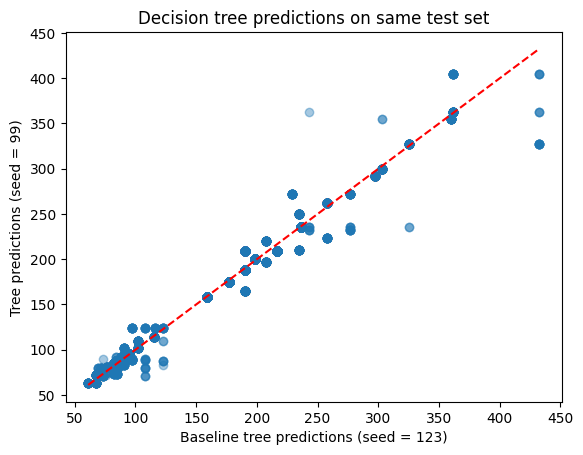

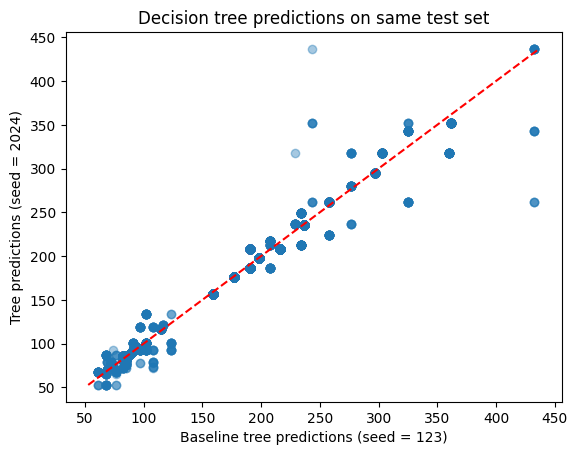

In [5]:
# scatterplots for tree predictions
for s in other_seeds:
    plt.figure()
    plt.scatter(y_hat_tree_base, alt_tree_preds[s], alpha=0.4)
    plt.xlabel("Baseline tree predictions (seed = {})".format(base_seed))
    plt.ylabel("Tree predictions (seed = {})".format(s))
    plt.title("Decision tree predictions on same test set")
    min_val = min(y_hat_tree_base.min(), alt_tree_preds[s].min())
    max_val = max(y_hat_tree_base.max(), alt_tree_preds[s].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # y = x line
    plt.show()


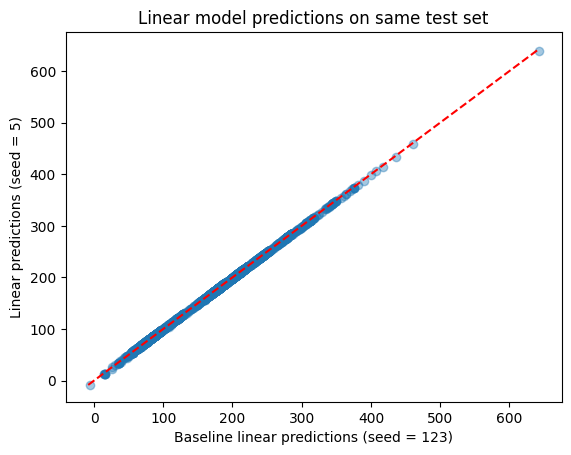

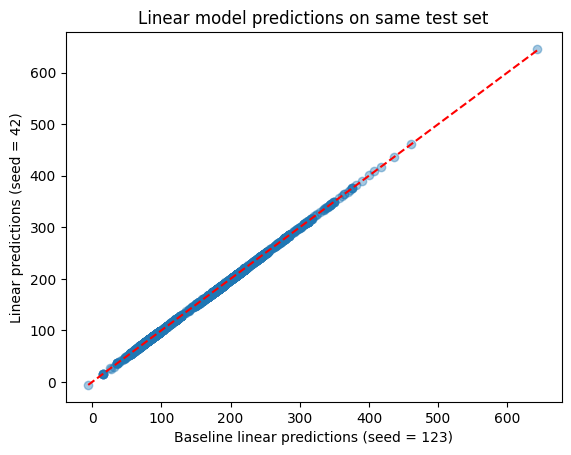

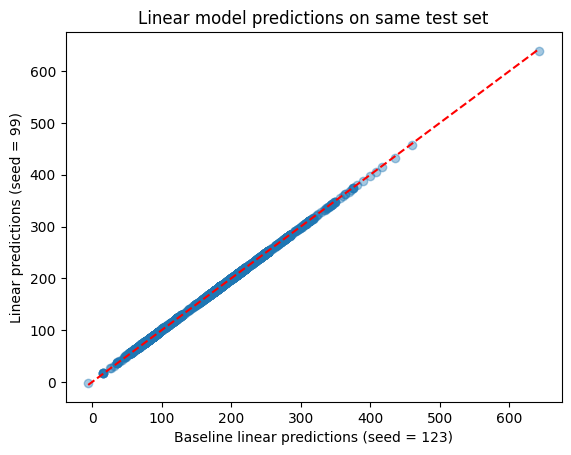

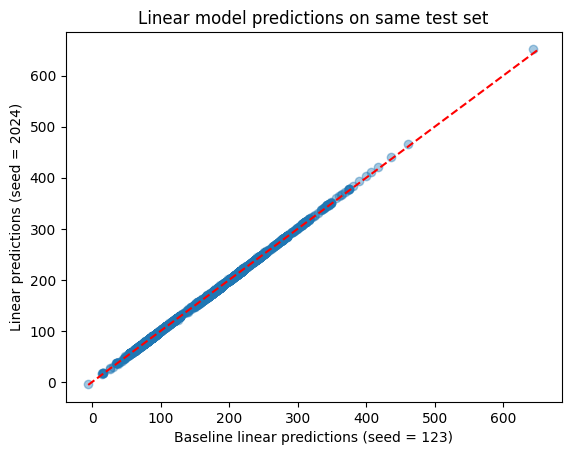

In [6]:
# scatterplots for linear model predictions
for s in other_seeds:
    plt.figure()
    plt.scatter(y_hat_lin_base, alt_lin_preds[s], alpha=0.4)
    plt.xlabel("Baseline linear predictions (seed = {})".format(base_seed))
    plt.ylabel("Linear predictions (seed = {})".format(s))
    plt.title("Linear model predictions on same test set")
    min_val = min(y_hat_lin_base.min(), alt_lin_preds[s].min())
    max_val = max(y_hat_lin_base.max(), alt_lin_preds[s].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # y = x line
    plt.show()


The scatterplots of baseline vs. alternative predictions were along the 45 degree line for both models. The linear model plots were tighter around the line, while the tree plots had a little bit more spread.

# Part 4b: Compute the correlation between your model in part 2 and your alternative models in part 3, separately for your trees and linear models. Are they highly correlated or not?

In [7]:
# correlations between predictions
y_hat_tree_base_series = pd.Series(y_hat_tree_base)
y_hat_lin_base_series = pd.Series(y_hat_lin_base)

print("Correlations for decision tree predictions:")
for s in other_seeds:
    r = y_hat_tree_base_series.corr(pd.Series(alt_tree_preds[s]))
    print("Seed", s, "correlation:", r)

print("\nCorrelations for linear model predictions:")
for s in other_seeds:
    r = y_hat_lin_base_series.corr(pd.Series(alt_lin_preds[s]))
    print("Seed", s, "correlation:", r)


Correlations for decision tree predictions:
Seed 5 correlation: 0.992717238007643
Seed 42 correlation: 0.9900833017572421
Seed 99 correlation: 0.991218983304498
Seed 2024 correlation: 0.9895030413877678

Correlations for linear model predictions:
Seed 5 correlation: 0.9999868951448326
Seed 42 correlation: 0.9999643182478316
Seed 99 correlation: 0.9999923687919775
Seed 2024 correlation: 0.9999311707092887


The correlations between baseline and alternative predictions were very high for both models. The trees had correlations close to 1, and the linear models were perfect, which means the predictions barely changed across seeds.

# Part 4c: Run a simple linear regression of the predicted values on the test set from the alternative models on the predicted values from question 2, separately for your trees and linear models. Is the intercept close to zero? Is the slope close to 1? Is the R^2 close to 1?

In [8]:
# SLR of the alternative predictions on baseline predictions
def slr(x, y):
    """Single linear regression: y on x."""
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    b1 = np.inner(x - x_bar, y - y_bar) / np.inner(x - x_bar, x - x_bar)
    b0 = y_bar - b1 * x_bar
    y_hat = b0 + b1 * x
    residuals = y - y_hat
    return {'b0': b0, 'b1': b1, 'y_hat': y_hat, 'residuals': residuals}

print("Decision trees: regress alt predictions on baseline predictions")
for s in other_seeds:
    x = y_hat_tree_base
    y_alt = alt_tree_preds[s]
    reg = slr(x, y_alt)
    SSE = np.sum(reg['residuals'] ** 2)
    TSS = np.sum((y_alt - np.mean(y_alt)) ** 2)
    R2 = 1 - SSE / TSS
    print("\nSeed", s)
    print("Intercept (b0):", reg['b0'])
    print("Slope (b1):", reg['b1'])
    print("R^2:", R2)

print("\nLinear models: regress alt predictions on baseline predictions")
for s in other_seeds:
    x = y_hat_lin_base
    y_alt = alt_lin_preds[s]
    reg = slr(x, y_alt)
    SSE = np.sum(reg['residuals'] ** 2)
    TSS = np.sum((y_alt - np.mean(y_alt)) ** 2)
    R2 = 1 - SSE / TSS
    print("\nSeed", s)
    print("Intercept (b0):", reg['b0'])
    print("Slope (b1):", reg['b1'])
    print("R^2:", R2)


Decision trees: regress alt predictions on baseline predictions

Seed 5
Intercept (b0): 1.9034969035854772
Slope (b1): 0.9811258887451376
R^2: 0.9854875146375229

Seed 42
Intercept (b0): 3.5669839825963265
Slope (b1): 0.9691004415267148
R^2: 0.9802649444185204

Seed 99
Intercept (b0): 3.026670783721414
Slope (b1): 0.9778730539846995
R^2: 0.9825150728632015

Seed 2024
Intercept (b0): 2.991660832848737
Slope (b1): 0.9767921864663622
R^2: 0.979116268915643

Linear models: regress alt predictions on baseline predictions

Seed 5
Intercept (b0): 0.257509428181919
Slope (b1): 0.9936667758757922
R^2: 0.9999737904614038

Seed 42
Intercept (b0): 0.26184409598900515
Slope (b1): 0.9936436588727632
R^2: 0.9999286377688528

Seed 99
Intercept (b0): 1.490967550857988
Slope (b1): 0.9896177713422643
R^2: 0.9999847376421915

Seed 2024
Intercept (b0): -0.0641099119180808
Slope (b1): 0.9993479617507227
R^2: 0.9998623461560472


When regressing the alternative predictions on the baseline predictions, the intercepts were close to 0, the slopes were close to 1, and the R^2 values were very close to 1 for both models (especially the linear ones).

# Question 5: Do linear models appear to have similar coefficients and predictions across train/test splits? Do trees?

Yes, the linear models had similar coefficients and predictions across different train/test splits. The trees did not look similar, but their predictions on the same test set were still very similar across seeds.

# Question 6: True or false, and explain: "Even if the models end up having a substantially different appearance, the predictions they generate are often very similar."

True. Even though the trees looked quite different from split to split, the predictions they produced were very close, and the linear models were even more stable.